In [2]:
from preprocessing import (
    preprocess_kjv,
    get_word_types_with_tf_idf,
    get_gospel_top_70_words_dictionary,
)
from extract_relations import (
    get_directed_relations,
    order_directed_relations,
)
from ontology_algorithm import (
    construct_ontology_hierarchy,
    print_hierarchy_tree_from_ontology,
    draw_hierarchy_tree_from_ontology,
)
from topic_modeling import (
    kmeans_tfidf_clustering,
    filter_topic_modeling_key_terms,
)
import re

## Preprocessing

We will preprocess words from the theology reconsidered text using tf-idf and extract the top n words.

In [3]:
kjv_path = "/Users/zebo/Documents/Freelancing/upwork/Peter_J_Worth_Jr/NLP/hierarchical_clustering/data/t_kjv.csv"
kjv_bible_df = preprocess_kjv(
    path_to_kjv=kjv_path,
)

# Get book column unique values.
all_books = kjv_bible_df["book"].unique()

# Specify the number of top words to use.
n = 70

books = []
for book in all_books:
    book_df = kjv_bible_df[kjv_bible_df["book"] == book]
    book_text = ""
    for chapter in book_df["chapter"].unique():
        chapter_df = book_df[book_df["chapter"] == chapter]
        book_text += " ".join(chapter_df["text"].values)
    books.append(" ".join(chapter_df["text"].values))


titles = all_books
chapters = books

## Perform topic modeling

In [4]:
NUM_TOPICS = 6
clusters, key_terms_per_cluster = kmeans_tfidf_clustering(
    chapters=chapters,
    num_topics=NUM_TOPICS,
    n_key_terms=10,
)

CLUSTER #1
Cluster Chapters: [1, 2, 18, 19, 20, 21, 26, 27, 28, 30, 31, 32, 33, 34, 35, 58, 65]
Key Features: ['shall', 'thy', 'thou', 'lord', 'thee', 'praise', 'upon', 'unto', 'let', 'shalt']
CLUSTER #2
Cluster Chapters: [0, 3, 4, 5, 6, 7, 8, 9, 12, 14, 17, 24, 25, 61]
Key Features: ['unto', 'israel', 'lord', 'said', 'inheritance', 'sons', 'god', 'thousand', 'joseph', 'land']
CLUSTER #3
Cluster Chapters: [22, 29, 36, 37, 38, 42]
Key Features: ['shall', 'saith', 'saith lord', 'lord', 'hosts', 'lord hosts', 'day', 'ye', 'saith unto', 'unto']
CLUSTER #4
Cluster Chapters: [39, 40, 41, 43, 60]
Key Features: ['unto', 'sepulchre', 'came', 'said', 'ye', 'shall', 'things', 'said unto', 'disciples', 'jesus']
CLUSTER #5
Cluster Chapters: [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 62, 63, 64]
Key Features: ['christ', 'jesus', 'ye', 'lord', 'unto', 'god', 'jesus christ', 'salute', 'lord jesus', 'brethren']
CLUSTER #6
Cluster Chapters: [10, 11, 13, 15, 16, 23]
Key Features: ['king

## Run the workflow on one cluster

In [5]:
# Specify the chapters used in the analysis.
chosen_cluster = 4
use_key_terms = True
chosen_hierarchy_depth = 5
chosen_hierarchy_max_width = 5
only_compounds = True

chosen_chapters = clusters[chosen_cluster]

chapter_titles = [titles[i] for i in chosen_chapters]
key_terms = key_terms_per_cluster[chosen_cluster]

print("Chosen chapters ", chosen_chapters)

text_per_chapter = []
for chapter_idx in chosen_chapters:
    text_per_chapter.append(chapters[chapter_idx])

tf_idf_pre_filtering = get_word_types_with_tf_idf(
    text_per_chapter,
    "tf",
    skip_stopwords=True,
    include_verbs=False,
    include_determiners=False,
    include_pronouns=False,
    include_adverbs=False,
    include_numbers=True,
)

if use_key_terms:
    current_level_words = filter_topic_modeling_key_terms(
        key_terms=key_terms_per_cluster[chosen_cluster],
        tf_idf_word_types=tf_idf_pre_filtering,
        verbose=True,
    )
    current_level_words.append("dàodé jīng") #TODO: Remove this.
else:
    raise NotImplementedError("Not implemented yet.")
    # Specify the number of top words to use.
    n = max(50, len(chosen_chapters)*5)
    current_level_words = tf_idf_pre_filtering.head(n)["word"].values

# Create a list of all verses of the chosen books.
all_verses = []
for chapter_idx in chosen_chapters:
    all_verses.extend(sentences_per_chapter[chapter_idx])

used_words = set()
all_ordered_directed_relations = []
all_relations_to_verbs = {}

# First, let's see relations between the key terms.
directed_relations, relations_to_verbs = get_directed_relations(
    top_n_words=current_level_words,
    all_verses=all_verses,
    verbose=False,
    only_compounds=only_compounds,
)

# Order the directed relations.
ordered_directed_relations = order_directed_relations(
    directed_relations=directed_relations,
    tf_idf_pre_filtering=tf_idf_pre_filtering,
    order_by="product",
    include_ordering_wrt_occurences=True,
    verbose=False,
)

for relation in ordered_directed_relations:
    if relation[0] in current_level_words and relation[1] in current_level_words:
        current_level_words.remove(relation[1])
        print("Removing ", relation[1], " from current_level_words, it will be a child of ", relation[0])


for current_level in range(chosen_hierarchy_depth):
    print("\n Current level: ", current_level)

    if len(current_level_words) == 0:
        break

    # Now lets see all relations that come out of the key terms.
    directed_relations, relations_to_verbs = get_directed_relations(
        top_n_words=current_level_words,
        all_verses=all_verses,
        verbose=False,
        get_all_one_directional='lower',
        only_compounds=only_compounds,
    )
    print("All children: ", [relation[1] for relation in directed_relations])
    
    # Filter out the relations whose children is not in tf_idf_pre_filtering
    # and it has not been used already, but print them out first.
    children_to_remove_1 = [
        key[1] for key, _ in directed_relations.items()
        if key[1] not in tf_idf_pre_filtering["word"].values
    ]
    # Keep the bigrams and trigrams which are not in tf_idf_pre_filtering but
    # all of their words are in tf_idf_pre_filtering.
    children_to_remove_1 = [
        child for child in children_to_remove_1
        if not (len(child.split(" ")) > 1 and
                all(word in tf_idf_pre_filtering["word"].values for word in child.split(" ")))
    ]
    print("Children to remove due to tf_idf_pre_filtering: ", children_to_remove_1)
    
    children_to_remove_2 = [
        key[1] for key, _ in directed_relations.items()
        if key[1] in used_words
    ]
    print("Children to remove due to used words: ", children_to_remove_2)

    directed_relations = {
        key: value for key, value in directed_relations.items()
        if key[1] not in children_to_remove_1 and key[1] not in children_to_remove_2
    }


    # Order the directed relations.
    ordered_directed_relations = order_directed_relations(
        directed_relations=directed_relations,
        tf_idf_pre_filtering=tf_idf_pre_filtering,
        order_by="product",
        include_ordering_wrt_occurences=True,
        verbose=False,
    )   

    # Constrain at most chosen_hierarchy_max_width relations per key term.
    if chosen_hierarchy_max_width is not None:
        counter = {}
        relations_to_remove = []
        for idx, relation in enumerate(ordered_directed_relations):
            if relation[0] in counter:
                counter[relation[0]] += 1
            else:
                counter[relation[0]] = 1
            if counter[relation[0]] > 5:
                relations_to_remove.append(relation)
        for relation in relations_to_remove:
            ordered_directed_relations.remove(relation)

    # Add parents and children to the used words.
    used_words.update([relation[0] for relation in ordered_directed_relations])
    used_words.update([relation[1] for relation in ordered_directed_relations])

    # Add the relations to the list of all relations.
    all_ordered_directed_relations.extend(ordered_directed_relations)
    all_relations_to_verbs.update(relations_to_verbs)

    # Set the current level words to the words that are the children of the current level words.
    current_level_words = [relation[1] for relation in ordered_directed_relations]
    print("Current level words ", current_level_words)


# Construct the ontology hierarchy.
ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
    ordered_directed_relations=all_ordered_directed_relations,
)

# Draw the ontology hierarchy.
draw_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    relations_to_verbs=all_relations_to_verbs,
    title="Theology reconsidered topic modeling cluster " + str(chosen_cluster) + " with " + str(len(chosen_chapters)) + " chapters",
    topic_modelling_chapters=chapter_titles,
)

Chosen chapters  [39, 40, 41, 43, 60]
Removing the following terms:  ['came', 'said', 'ye', 'said unto']


NameError: name 'sentences_per_chapter' is not defined

In [9]:
tf_idf_pre_filtering[tf_idf_pre_filtering['word']=='classical chinese']

,word,word_type,tc,tf,dc,idf,tf_idf
226,classical chinese,"{'NNPS': 7, 'NNP': 102, 'JJ': 226, 'GPE': 280,...",19,0.000474,7,0.0,0.0


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc_1 = nlp(all_verses[525])
spacy.displacy.render(doc_1, style="dep", jupyter=True)

## Run for all clusters of the text

Removing the following terms:  ['also', 'well', 'one', 'first', 'writing', 'written', 'see', 'much', 'sumer', 'even', 'perhaps', 'sumer babylonian', 'find']


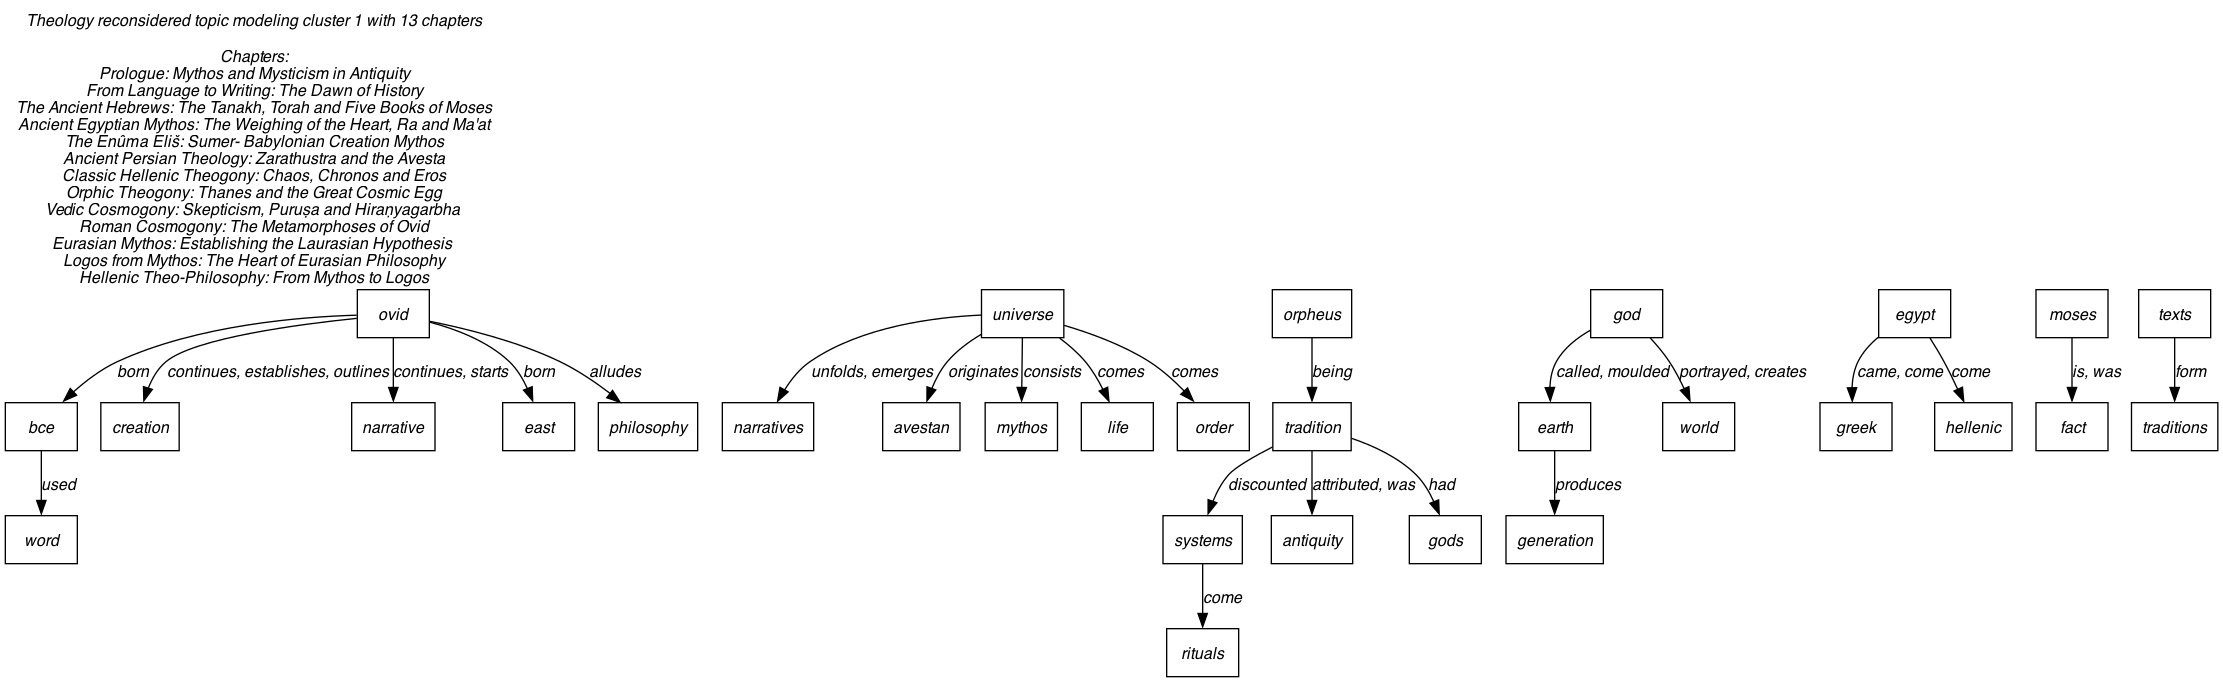

Removing the following terms:  ['subject object', 'metaphysics quality', 'static quality', 'object metaphysics', 'dynamic quality', 'one', 'even', 'subjectobject', 'motorcycle maintenance', 'subjects objects', 'aspect quality', 'subjectobject metaphysics', 'zen art', 'art motorcycle']


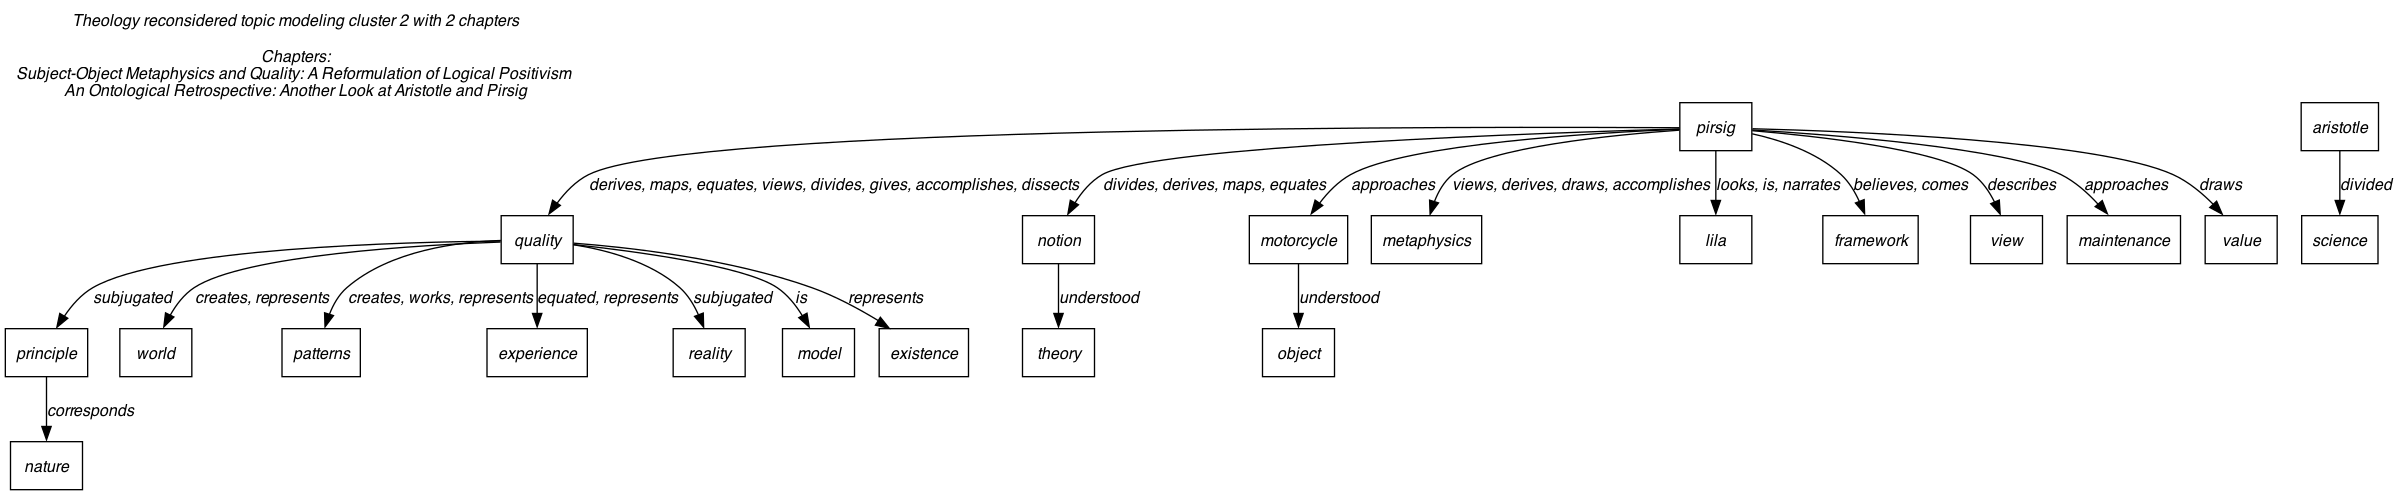

Removing the following terms:  ['suffering', 'one', 'also', 'well', 'first', 'works', 'form knowledge', 'said', 'know', 'two']


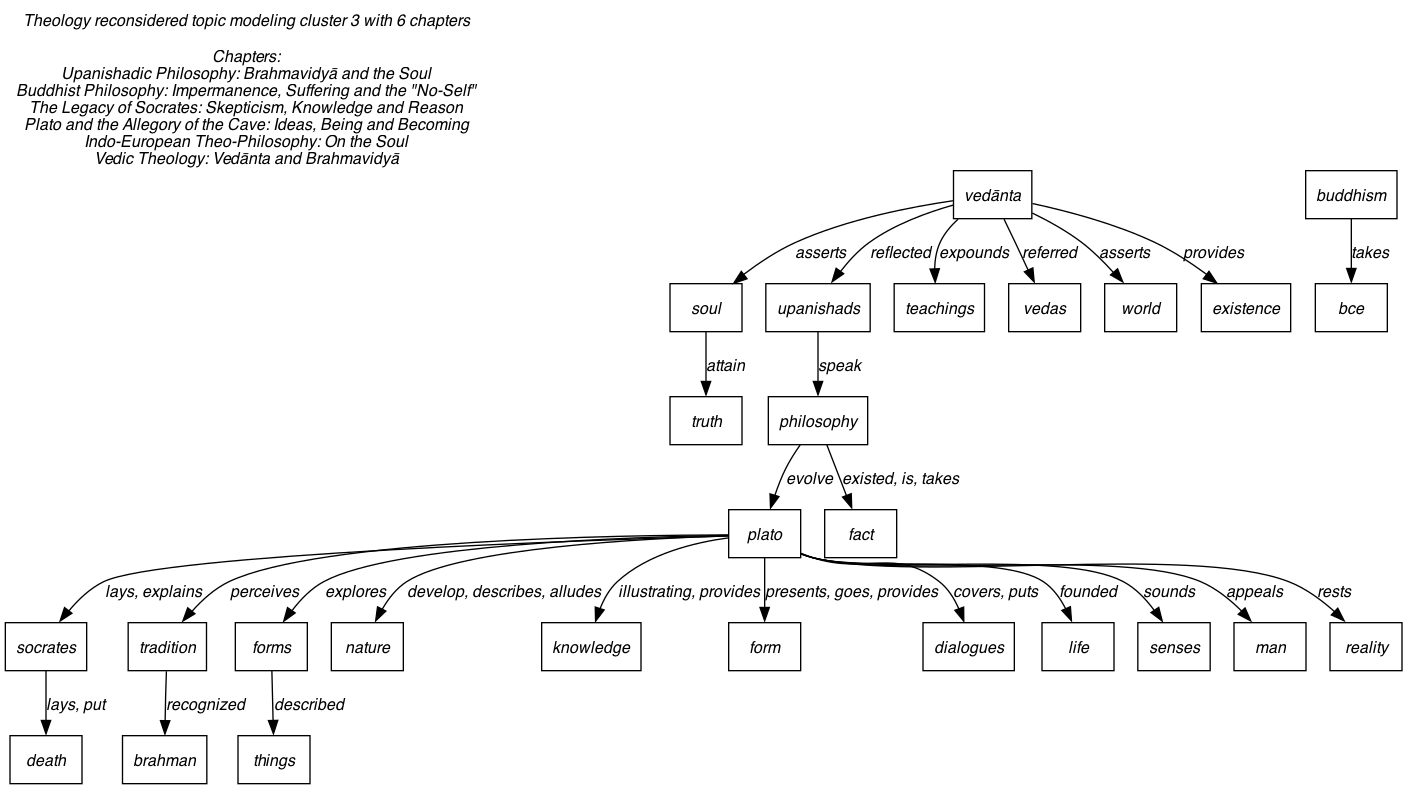

Removing the following terms:  ['well', 'theo', 'theo philosophical', 'also', 'one', 'find', 'even', 'first', 'much', 'theophilosophical', 'indo', 'throughout eurasia']


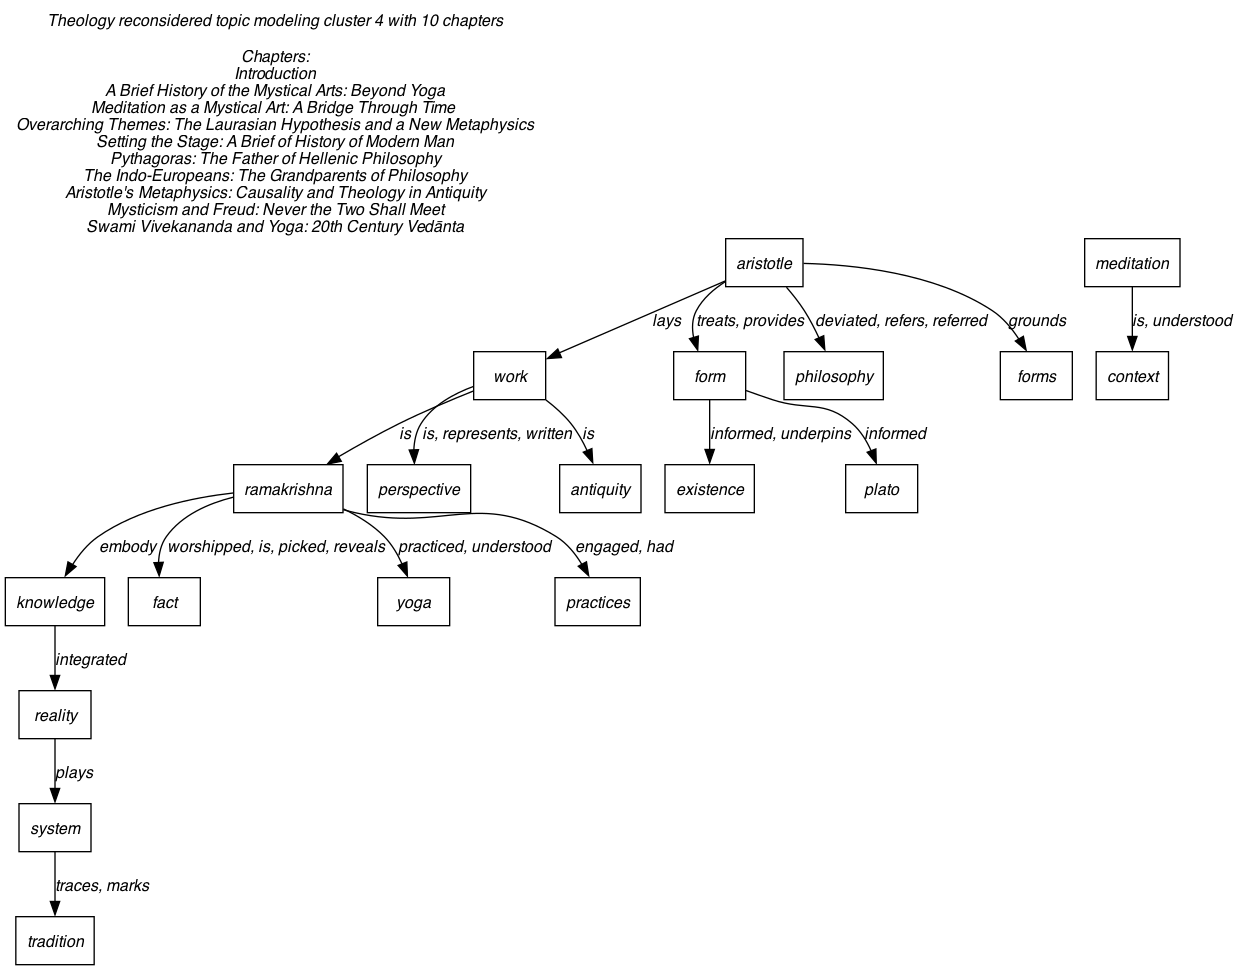

Removing the following terms:  ['quantum theory', 'quantum mechanics', 'classical mechanics', 'one', 'well', 'even', 'defined', 'underlying']


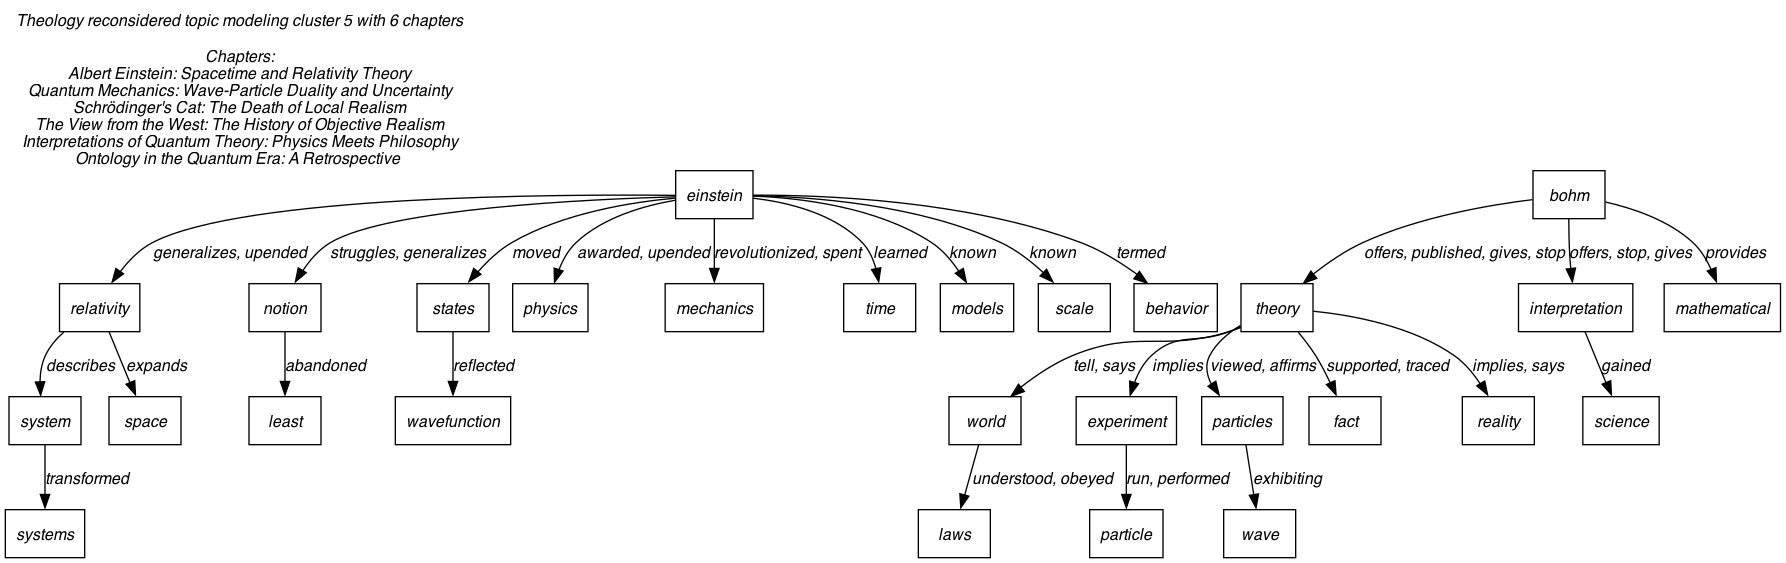

Removing the following terms:  ['one', 'well', 'also', 'metaphysics awareness']


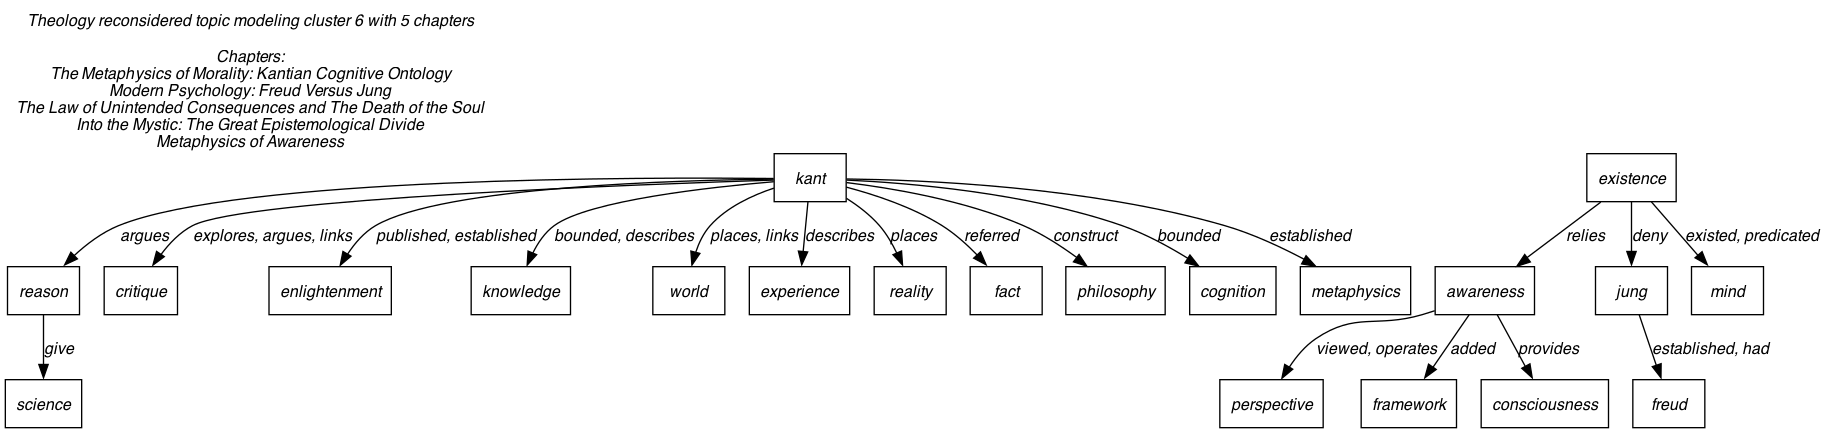

Removing the following terms:  ['one', 'ancient chinese', 'also', 'heaven earth', 'well', 'first', 'dàodé jīng', 'zhou dynasty', 'chinese antiquity', 'writing', 'see', 'form', 'chinese philosophical', 'two', 'even', 'written', 'eight']


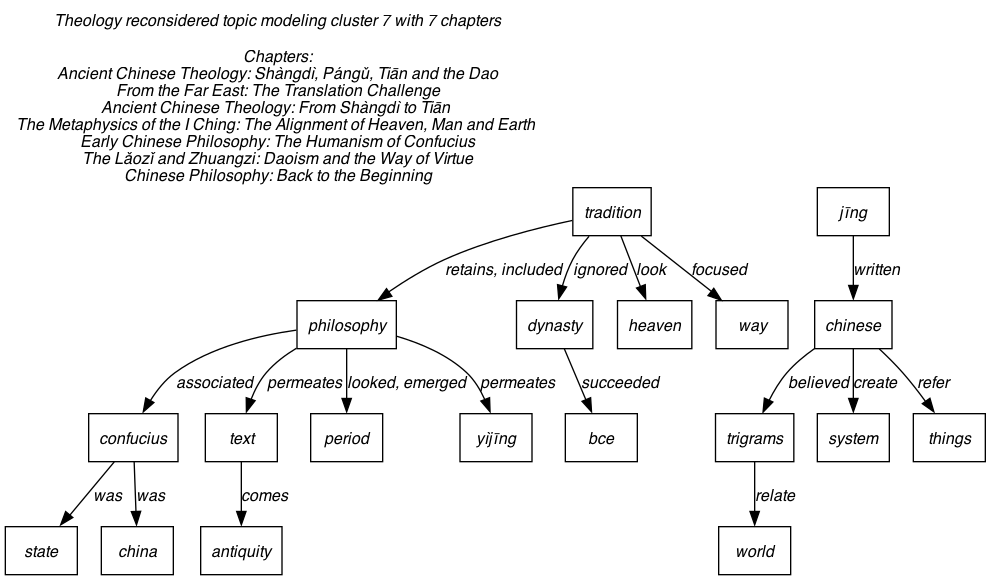

Removing the following terms:  ['al', 'one', 'also', 'well', 'first', 'works', 'muammad', 'salvation', 'old testament', 'qurn']


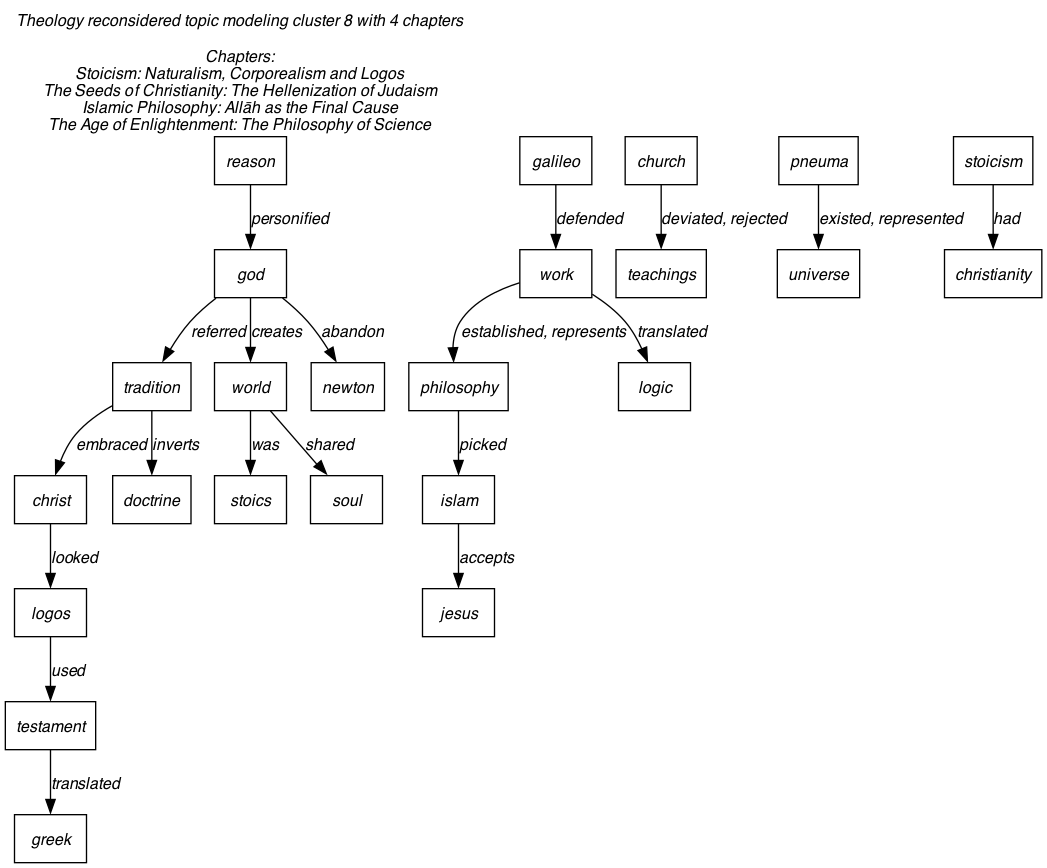

In [15]:
use_key_terms = True

# Specify the chapters used in the analysis.
for cluster in range(1, NUM_TOPICS+1):
    #print("Cluster: #", cluster)
    chosen_chapters = clusters[cluster]

    chapter_titles = [titles[i] for i in chosen_chapters]
    #print("Chosen chapters \n")
    # for title in chapter_titles:
    #     print(title)

    # Specify the number of top words to use.
    n = max(50, len(chosen_chapters)*5)

    text_per_chapter = []
    for chapter_idx in chosen_chapters:
        text_per_chapter.append(chapters[chapter_idx])

    tf_idf_pre_filtering = get_word_types_with_tf_idf(
        text_per_chapter,
        "tf",
        skip_stopwords=True,
        include_verbs=False,
        include_determiners=False,
        include_pronouns=False,
        include_adverbs=False,
        include_numbers=False,
    )

    if use_key_terms:
        current_level_words = current_level_words = filter_topic_modeling_key_terms(
            key_terms=key_terms_per_cluster[cluster],
            tf_idf_word_types=tf_idf_pre_filtering,
            verbose=True,
        )
    else:
        current_level_words = tf_idf_pre_filtering.head(n)["word"].values

    # Create a list of all verses of the chosen books.
    all_verses = []
    for chapter_idx in chosen_chapters:
        all_verses.extend(sentences_per_chapter[chapter_idx])
    directed_relations, relations_to_verbs = get_directed_relations(
        top_n_words=current_level_words,
        all_verses=all_verses,
        verbose=False,
    )
    ordered_directed_relations = order_directed_relations(
        directed_relations=directed_relations,
        tf_idf_pre_filtering=tf_idf_pre_filtering,
        order_by="product",
        include_ordering_wrt_occurences=True,
        verbose=False,
    )
    ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
        ordered_directed_relations=ordered_directed_relations,
    )
    # print_hierarchy_tree_from_ontology(
    #     ontological_hierarchy=ontology_hierarchy,
    #     words_with_parents=words_with_parents,
    # )
    draw_hierarchy_tree_from_ontology(
        ontological_hierarchy=ontology_hierarchy,
        relations_to_verbs=relations_to_verbs,
        title="Theology reconsidered topic modeling cluster " + str(cluster) + " with " + str(len(chosen_chapters)) + " chapters",
        topic_modelling_chapters=chapter_titles,
    )